In [1]:
%matplotlib ipympl
from main_structure import Framework
import support_functions
import math
import numpy as np
from datetime import datetime
import constants
from pyquaternion import Quaternion
import matplotlib.pyplot as plt

from matplotlib.widgets import Slider, Button
 

In [6]:

iss_posn = np.array([7e6, math.radians(0.05), math.radians(50), math.radians(311.6218), math.radians(199.2431), math.radians(48.4420)])
xyz = support_functions.kep_to_cart(iss_posn)[:3]
magnetometer = support_functions.igdf_eci_vector(xyz[0], xyz[1], xyz[2], datetime.now())
framework = Framework(iss_posn, magnetometer, False, 1)
random_4 = []
random_3 = [0.2, 0.3, 0.6]
if(np.linalg.norm(random_3) < 1):
    random_4 = np.array([random_3[0], random_3[1], random_3[2], math.sqrt(1 - np.linalg.norm(random_3)**2)])
true_rot = Quaternion(random_4)
true_posn = iss_posn
true_position_history = [xyz]
estimated_position_history = [xyz]
attitude_error_history = [0]
time_range = int(90*60/constants.DT)
revolutions = 1
use_noise = True
resets_per_orbit = 3

In [7]:
def smallest_angle(a1, a2):
    return min(abs(a1 - a2), math.pi * 2 - abs(a2 - a1))

def smallest_angles(a1, a2):
    to_ret = []
    for i in range(len(a1)):
        to_ret.append(smallest_angle(a1[i], a2[i]))
    return np.array(to_ret)

for i in range(time_range * revolutions):#1 revolution
    time = datetime.now()
    xyz = support_functions.kep_to_cart(true_posn)[:3]
    if(i % (time_range/resets_per_orbit) == 0):
        print("RESET")
        framework.orbit_determination.kf.x = np.concatenate([support_functions.kep_to_cart(true_posn),
                                                             framework.get_mag_bias()])
    true_position_history.append(xyz)
    estimated = framework.orbit_determination.kf.x[:3]
    estimated_position_history.append(estimated)
    attitude_error_history.append(np.degrees(np.sum(smallest_angles(framework.get_rotation_from_eci().yaw_pitch_roll, true_rot.yaw_pitch_roll))))
    mag = support_functions.igdf_eci_vector(xyz[0], xyz[1], xyz[2], time)
    magnetometer = true_rot.rotate(mag)
    sun = true_rot.rotate(support_functions.eci_sun_vector(time))
    if(use_noise):
        magnetometer_magnitude = np.linalg.norm(magnetometer)
        old_mag = np.copy(magnetometer)
        magnetometer += np.random.normal(loc = 1000, scale = 300, size = 3)
        sun += np.random.normal(loc = 0, scale = 0.05, size = 3)
        sun = sun / np.linalg.norm(sun)

    
    framework.propagate(np.concatenate([magnetometer], axis = 0), time)
    true_posn = support_functions.propagate_orbit(true_posn, constants.DT)

RESET
RESET
RESET


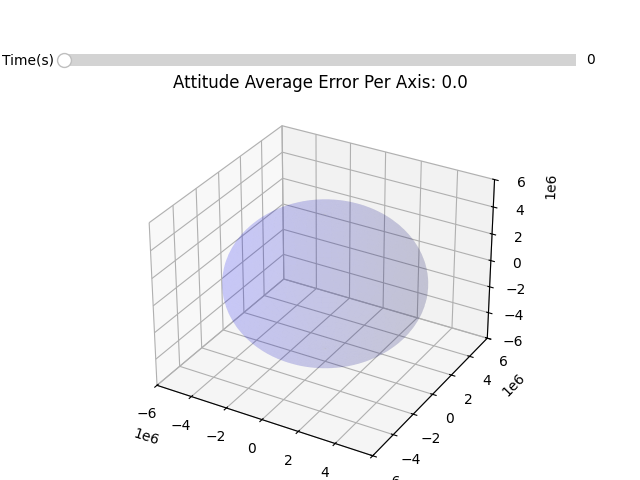

In [9]:
%matplotlib ipympl
true_position_history = np.array(true_position_history)
estimated_position_history = np.array(estimated_position_history)


fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 0.8], projection = '3d')
slider = Slider(
    ax=fig.add_axes([0.1, 0.85, 0.8, 0.05]),
    label='Time(s)',
    valmin = 0,
    valmax= time_range,
    valstep = np.arange(0, time_range, 1),
    valinit=0,
)


def update(val):
    ax.clear()
    ax.axes.set_xlim3d(left=-6e6, right=6e6) 
    ax.axes.set_ylim3d(bottom=-6e6, top=6e6) 
    ax.axes.set_zlim3d(bottom=-6e6, top=6e6) 
    radius = 5e6
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='blue', alpha = 0.1)
    ax.set_title(f"Attitude Average Error Per Axis: {attitude_error_history[val]/3}")
    if(val >= 20):
        ax.plot(estimated_position_history[:, 0][val - 20:val], estimated_position_history[:, 1][val - 20:val], estimated_position_history[:, 2][val-20:val],
                color = 'red', alpha = 0.8)
        ax.plot(true_position_history[:, 0][val-20:val], true_position_history[:, 1][val-20:val], true_position_history[:, 2][val-20:val],
                color = 'g', alpha = 0.5)
    else:
        ax.plot(estimated_position_history[:, 0][:val], estimated_position_history[:, 1][:val], estimated_position_history[:, 2][:val],
                color = 'red', alpha = 0.8)
        ax.plot(true_position_history[:, 0][:val], true_position_history[:, 1][:val], true_position_history[:, 2][:val],
                color = 'g', alpha = 0.5)




slider.on_changed(update)
update(0)
plt.show()

In [8]:
print(framework.get_mag_bias())

[ 306.30333002   55.05984633 1258.90228268]
